In [192]:
import pandas as pd
import yfinance as yf
from scipy.stats import linregress
import numpy as np
import os
from datetime import datetime, timedelta

def fetch_sp500_tickers():
    """Fetches the list of S&P 500 tickers."""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500_list = pd.read_html(url)[0]
    return sp500_list['Symbol'].values.tolist()

def should_fetch_new_data(filepath):
    """Determines if new data should be fetched based on the last date in the file.
        First return value: True (update the data); False (Do not update data)
        Second return value: True (completely replace the existing data); False (Do not completely replace data)
    """
    should_update = False
    should_replace= False
    if not os.path.exists(filepath):
        should_replace = True
        return (should_update, should_replace)
    else:
        if os.path.getsize(filepath) == 0:
            should_replace = True
            return (should_update, should_replace)

        # file exist and is not empty, check the data
        existing_data = pd.read_csv(filepath, index_col='Date', parse_dates=['Date'])
        last_date = existing_data.index.max()

        # some invalid number in the file, completely replace the file
        if pd.isna(last_date):
            should_replace = True
            return (should_update, should_replace)

        # Ensure last_date is a datetime object (should be if coming from a pandas Timestamp)
        if isinstance(last_date, pd.Timestamp):
            # Convert to a "naive" datetime object, if it's not already
            last_date_naive = last_date.to_pydatetime().replace(tzinfo=None)
        else:
            last_date_naive = last_date

        # Check if the current date is more than 7 days from the last date in the file
        if datetime.now() - last_date_naive <= timedelta(days=7):
            should_update = False
            should_replace = False
            return (should_update, should_replace)  # No need to fetch new data

        should_update = True
        should_replace = False
        return (should_update, should_replace)  # File doesn't exist, is empty, or it's been more than 7 days

def fetch_and_save_weekly_stock_data(ticker, data_dir='../data/stock_data'):
    """Fetches historical weekly stock data and appends new data to the existing CSV file if needed."""
    filepath = os.path.join(data_dir, f"{ticker}_weekly.csv")
    should_update, should_replace = should_fetch_new_data(filepath)
    if should_replace:
        updated_data = yf.Ticker(ticker).history(period="5y", interval="1wk")
        updated_data.to_csv(filepath)
    elif should_update:
        # Load existing data
        existing_data = pd.read_csv(filepath, index_col='Date', parse_dates=True)
        last_date = existing_data.index.max()

        # Fetch new data starting from the day after the last date in the existing data
        new_data_start_date = last_date + pd.Timedelta(days=1)
        new_data = yf.Ticker(ticker).history(start=new_data_start_date.strftime('%Y-%m-%d'), interval="1wk")

        if not new_data.empty:
            # Append new data directly to the CSV, without reading the entire file into memory
            new_data.to_csv(filepath, mode='a', header=False)

        print(f"Fetching new data for {ticker}...")

def fetch_and_save_daily_stock_data(ticker, data_dir='../data/stock_data'):
    """Fetches historical weekly stock data and appends new data to the existing CSV file if needed."""
    filepath = os.path.join(data_dir, f"{ticker}_daily.csv")
    should_update, should_replace = should_fetch_new_data(filepath)
    if should_replace:
        updated_data = yf.Ticker(ticker).history(period="2y", interval="1d")
        updated_data.to_csv(filepath)
    elif should_update:
        # Load existing data
        existing_data = pd.read_csv(filepath, index_col='Date', parse_dates=True)
        last_date = existing_data.index.max()

        # Fetch new data starting from the day after the last date in the existing data
        new_data_start_date = last_date + pd.Timedelta(days=1)
        new_data = yf.Ticker(ticker).history(start=new_data_start_date.strftime('%Y-%m-%d'), interval="1d")

        if not new_data.empty:
            # Append new data directly to the CSV, without reading the entire file into memory
            new_data.to_csv(filepath, mode='a', header=False)

        print(f"Fetching new data for {ticker}...")

def load_stock_data_into_memory(tickers, interval='daily', data_dir='../data/stock_data'):
    """
    Reads stock data for each ticker from CSV files and stores them in memory.

    Parameters:
    - tickers: List of ticker symbols.
    - data_dir: Directory where the stock data CSV files ares stored.

    Returns:
    A dictionary where keys are ticker symbols and values are DataFrames of stock data.
    """
    stock_data = {}
    index_col = 'Date'
    if interval == 'hourly':
        index_col = 'Datetime'
    for ticker in tickers:
        filepath = os.path.join(data_dir, f"{ticker}_{interval}.csv")
        if os.path.exists(filepath):
            stock_data[ticker] = pd.read_csv(filepath, index_col=index_col, parse_dates=[index_col])
        else:
            print(f"Data for {ticker} not found in {data_dir}.")
    return stock_data

# tickers = fetch_sp500_tickers()
# for ticker in tickers:  # Example: Process only the first 5 tickers for demonstration
#     # fetch_and_save_weekly_stock_data(ticker)
#     fetch_and_save_daily_stock_data(ticker)

# stock_data = load_stock_data_into_memory(tickers)

In [200]:
fetch_and_save_daily_stock_data('AAPL')
tickers=['AAPL']
stock_data = load_stock_data_into_memory(tickers)
AAPL_stock = stock_data['AAPL']
print(AAPL_stock)

                                 Open        High         Low       Close  \
Date                                                                        
2022-02-09 00:00:00-05:00  174.282963  174.876932  173.144497  174.510651   
2022-02-10 00:00:00-05:00  172.392155  173.718702  169.828154  170.392426   
2022-02-11 00:00:00-05:00  170.600323  171.342795  166.353373  166.947357   
2022-02-14 00:00:00-05:00  165.690113  167.877938  164.888245  167.184967   
2022-02-15 00:00:00-05:00  169.253985  171.214108  168.541210  171.055710   
...                               ...         ...         ...         ...   
2024-02-02 00:00:00-05:00  179.860001  187.330002  179.250000  185.850006   
2024-02-05 00:00:00-05:00  188.149994  189.250000  185.839996  187.679993   
2024-02-06 00:00:00-05:00  186.860001  189.309998  186.770004  189.300003   
2024-02-07 00:00:00-05:00  190.639999  191.050003  188.610001  189.410004   
2024-02-08 00:00:00-05:00  189.384995  189.535004  187.350006  188.320007   

In [216]:
def maxProfit(df, initial_money=1000):
    prices = df['Close'].tolist()  # Convert the 'Close' column to a list
    valley = prices[0]
    peak = prices[0]
    res = 0
    i = 0
    buys = []  # To store the indices of buy points
    sells = []  # To store the indices of sell points
    current_money = initial_money
    df['signal'] = 0
    df['current_money'] = initial_money

    while i < len(prices) - 1:
        while i < len(prices) - 1 and prices[i] >= prices[i + 1]:
            i += 1
        valley = prices[i]
        df.iloc[i, df.columns.get_loc('signal')] = 1
 
        # buys.append(df.index[i])  # Append the timestamp/date of the buy point
        num_shares = current_money/valley
        current_money = 0

        while i < len(prices) - 1 and prices[i] <= prices[i + 1]:
            i += 1
        peak = prices[i]
        df.iloc[i, df.columns.get_loc('signal')] = -1

        # sells.append(df.index[i])  # Append the timestamp/date of the sell point
        current_money = num_shares*peak
        num_shares = 0
        df.iloc[i, df.columns.get_loc('current_money')] = current_money

    df['EMA5'] = df['Close'].ewm(span=5, adjust=False).mean().shift(-1)
    df['MA5'] = df['Close'].rolling(window=5).mean().shift(-1)
    df['MA3'] = df['Close'].rolling(window=3).mean().shift(-1)

    profit_or_loss = current_money-initial_money

    # clean up the 'current_money row in df to make it non-decreasing
    for i in range(1,len(prices)):
        if df.iloc[i, df.columns.get_loc('current_money')] < df.iloc[i-1, df.columns.get_loc('current_money')]:
            df.iloc[i, df.columns.get_loc('current_money')] = df.iloc[i-1, df.columns.get_loc('current_money')]

    return df, profit_or_loss

    # # Optionally, print buy and sell dates for visualization
    # print("Buy Dates:", buys, "\nSell Dates:", sells)


end_time = AAPL_stock.index.max()
start_time = end_time - timedelta(days=180)
df = AAPL_stock[(AAPL_stock.index >= start_time) & (AAPL_stock.index <= end_time)].copy()
df, profit_or_loss = maxProfit(df, initial_money=1000)
print(profit_or_loss)

845.8803767114994


/var/folders/jb/x5q2pkmx3p5_x479n8vzms6c0000gn/T/ipykernel_3105/2940216784.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1040.919504742647' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('current_money')] = current_money


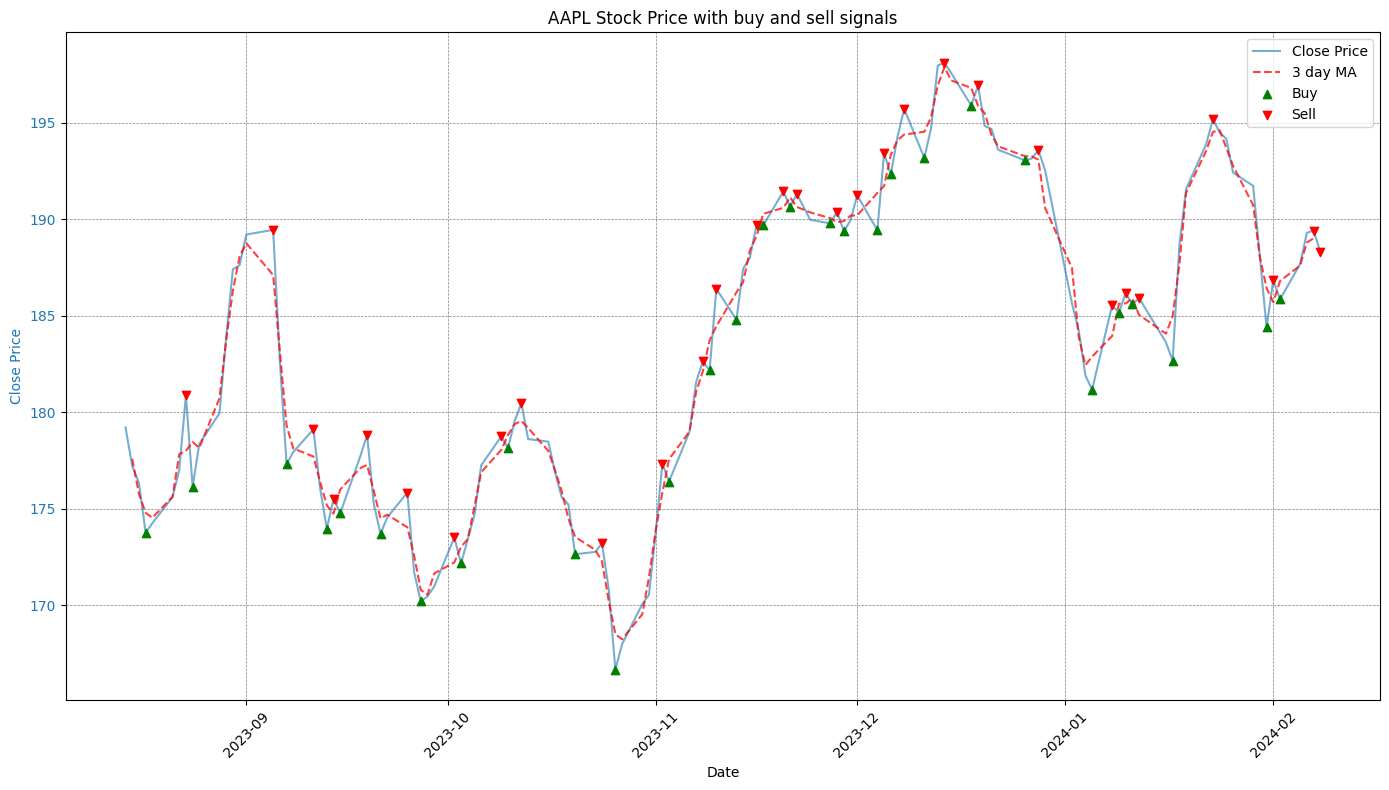

In [217]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_stock_price_with_buy_sell_signal(df, ticker):
    # Create a figure and a grid of subplots
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plotting the closing price and 30-week MA
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(df.index, df['Close'], label='Close Price', color=color, alpha=0.6)
    ax1.plot(df.index, df['MA3'], label='3 day MA', color='red', linestyle='--', alpha=0.75)
    # ax1.plot(df.index, df['MA5'], label='5 day MA', color='red', linestyle='--', alpha=0.75)
    # ax1.plot(df.index, df['EMA5'], label='5 day EMA', color='green', linestyle='--', alpha=0.75)

    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')

    # Now, filter the DataFrame for buy and sell signals and plot them directly
    buy_signals = df[df['signal'] == 1]  # Buy signals where 'signal' column is 1
    sell_signals = df[df['signal'] == -1]  # Sell signals where 'signal' column is -1

    # Plot buy signals
    ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy', alpha=1, zorder=5)
    # Plot sell signals
    ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell', alpha=1, zorder=5)

    #axs[0].set_title('Stock Price and RSI')
    ax1.legend()

    # Rotating the date labels to improve readability
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    plt.title(f"{ticker} Stock Price with buy and sell signals")
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

plot_stock_price_with_buy_sell_signal(df, 'AAPL')

In [180]:
from datetime import datetime, timedelta

# download AMZN stock in hour interval for the past 6 months
def fetch_and_save_hourly_stock_data(ticker, period='1y', data_dir='../data/stock_data'):
    """Fetches historical hourly stock data and appends new data to the existing CSV file if needed."""
    filepath = os.path.join(data_dir, f"{ticker}_hourly.csv")
    updated_data = yf.Ticker(ticker).history(period=period, interval="1h")
    updated_data.to_csv(filepath)

    print(f"Fetching new data for {ticker}...")

# download AMZN stock in 5m interval for the past 6 months
def fetch_and_save_5m_stock_data(ticker, period='1mo', data_dir='../data/stock_data'):
    """Fetches historical hourly stock data and appends new data to the existing CSV file if needed."""
    filepath = os.path.join(data_dir, f"{ticker}_5m.csv")
    updated_data = yf.Ticker(ticker).history(period=period, interval="5m")
    updated_data.to_csv(filepath)

    print(f"Fetching new data for {ticker}...")

# download AMZN stock in 1m interval for the past 6 months
def fetch_and_save_1m_stock_data(ticker, period='1d', data_dir='../data/stock_data'):
    """Fetches historical hourly stock data and appends new data to the existing CSV file if needed."""
    filepath = os.path.join(data_dir, f"{ticker}_1m.csv")
    updated_data = yf.Ticker(ticker).history(period=period, interval="1m")
    updated_data.to_csv(filepath)

    print(f"Fetching new data for {ticker}...")

def load_stock_data_into_memory(tickers,  data_dir='../data/stock_data'):
    stock_data = {}
    index_col = 'Datetime'
    for ticker in tickers:
        filepath = os.path.join(data_dir, f"{ticker}_1m.csv")
        if os.path.exists(filepath):
            stock_data[ticker] = pd.read_csv(filepath, index_col=index_col, parse_dates=['Datetime'])
        else:
            print(f"Data for {ticker} not found in {data_dir}.")
    return stock_data

fetch_and_save_1m_stock_data('AAPL')
tickers=['AAPL']
stock_data = load_stock_data_into_memory(tickers)


Fetching new data for AAPL...


Buying at 2024-02-08 09:54:00-05:00, Price: 188.75999450683597
Selling at 2024-02-08 10:56:00-05:00, Price: 188.0, Profit: -40.26247769404472
Buying at 2024-02-08 12:18:00-05:00, Price: 188.26499938964844
Selling at 2024-02-08 12:33:00-05:00, Price: 188.56979370117188, Profit: -24.138018283601923
Buying at 2024-02-08 12:51:00-05:00, Price: 188.2250061035156
Selling at 2024-02-08 13:40:00-05:00, Price: 188.27999877929688, Profit: -21.223424973413785
Buying at 2024-02-08 14:17:00-05:00, Price: 188.05999755859372
Selling at 2024-02-08 14:46:00-05:00, Price: 188.125, Profit: -17.774287208629175
Buying at 2024-02-08 15:43:00-05:00, Price: 188.2949981689453
Final Sale at 2024-02-08 15:59:00-05:00, Price: 188.33999633789065, Total Profit: -15.38876511063063


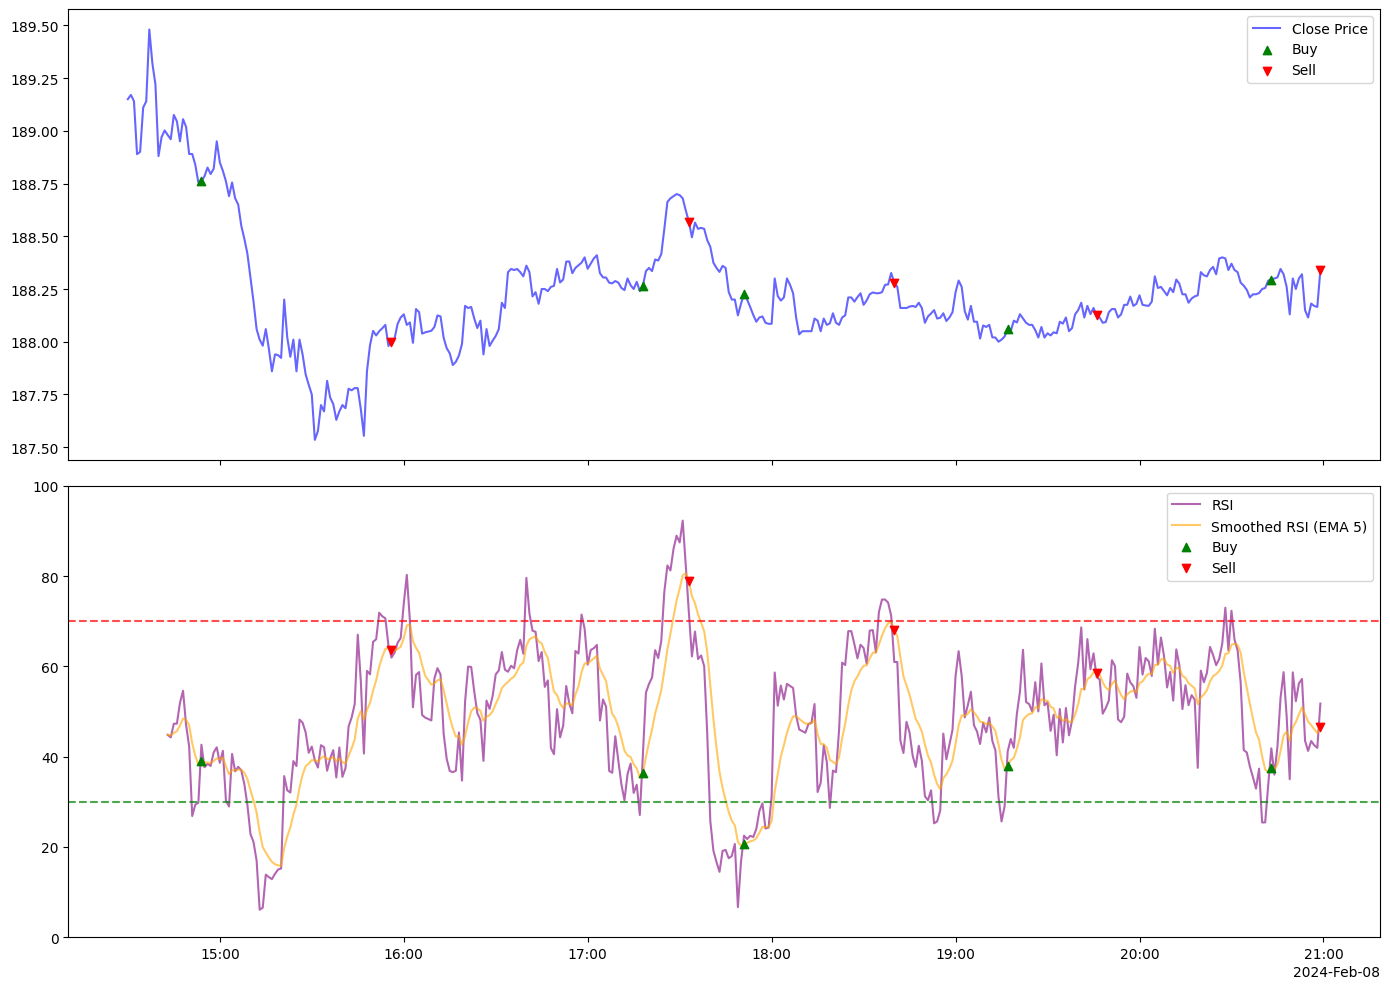

In [187]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


AAPL_stock = stock_data['AAPL']
end_time = AAPL_stock.index.max()
start_time = end_time - timedelta(days=1)

df = AAPL_stock[(AAPL_stock.index >= start_time) & (AAPL_stock.index <= end_time)].copy()

def calculate_rsi(df, periods=14):
    """Calculate Relative Strength Index (RSI)."""
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI_Smoothed'] = df['RSI'].ewm(span=9, adjust=False).mean()


def apply_strategy(df, initial_balance=10000):
    """Apply MACD and RSI strategy to generate buy/sell signals."""
    position = 0
    balance = initial_balance
    df['RSI_Diff'] = df['RSI_Smoothed'].diff()
    df['signal'] = 0
    price_paid = 0
    for i in range(15, len(df)):
        # Buy signal: MACD crosses above MACD signal line and RSI < 30 (oversold)
        # if df['MACD'].iloc[i] > df['MACD_Signal'].iloc[i] and df['MACD'].iloc[i-1] < df['MACD_Signal'].iloc[i-1] and df['RSI'].iloc[i] < 30:
        if position == 0:
            if df['RSI_Diff'].iloc[i-1]<=0 and df['RSI_Diff'].iloc[i]>0 and df['RSI'].iloc[i]< 45:
                position = balance / df['Close'].iloc[i]
                balance = 0
                df.at[df.index[i], 'signal'] = 1  # Use .at for setting buy signal
                price_paid = df['Close'].iloc[i]
                print(f"Buying at {df.index[i]}, Price: {df['Close'].iloc[i]}")

        # Sell signal: MACD crosses below MACD signal line and RSI > 70 (overbought)
        # elif df['MACD'].iloc[i] < df['MACD_Signal'].iloc[i] and df['MACD'].iloc[i-1] > df['MACD_Signal'].iloc[i-1] and df['RSI'].iloc[i] > 70:
        else:
            if ((df['RSI_Diff'].iloc[i-1]>=0 and df['RSI_Diff'].iloc[i]<0 and df['RSI'].iloc[i]>55) or
                df['Close'].iloc[i]<0.99*price_paid or 
                df['Close'].iloc[i]>1.03*price_paid):
                balance = df['Close'].iloc[i]*position
                position = 0
                df.at[df.index[i], 'signal'] = -1  # Use .at for setting buy signal
                print(f"Selling at {df.index[i]}, Price: {df['Close'].iloc[i]}, Profit: {balance-initial_balance}")

    # Assuming you want to close any open position at the end of the period
    if position > 0:
        balance += df['Close'].iloc[-1] * position
        position = 0
        df.at[df.index[-1], 'signal'] = -1  # Mark the final sell signal
        print(f"Final Sale at {df.index[-1]}, Price: {df['Close'].iloc[-1]}, Total Profit: {balance - initial_balance}")

    return df, balance-initial_balance


# Assuming df is your DataFrame and it has a 'Close' column
# calculate_macd(df)
calculate_rsi(df)

df, profit_or_loss = apply_strategy(df)


# Assuming df is your DataFrame prepared with 'Close', 'RSI', and 'RSI_Smoothed_EMA' columns

# Create a figure and a grid of subplots with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the Close price on the first subplot
axs[0].plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.6)
# Now, filter the DataFrame for buy and sell signals and plot them directly
buy_signals = df[df['signal'] == 1]  # Buy signals where 'signal' column is 1
sell_signals = df[df['signal'] == -1]  # Sell signals where 'signal' column is -1

# Plot buy signals
axs[0].scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy', alpha=1, zorder=5)
# Plot sell signals
axs[0].scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell', alpha=1, zorder=5)

#axs[0].set_title('Stock Price and RSI')
axs[0].legend()

# Plotting RSI and Smoothed RSI on the second subplot
axs[1].plot(df.index, df['RSI'], label='RSI', color='purple', alpha=0.6)
axs[1].plot(df.index, df['RSI_Smoothed'], label='Smoothed RSI (EMA 5)', color='orange', alpha=0.6)
# Plot buy signals
axs[1].scatter(buy_signals.index, buy_signals['RSI_Smoothed'], marker='^', color='green', label='Buy', alpha=1, zorder=5)
# Plot sell signals
axs[1].scatter(sell_signals.index, sell_signals['RSI_Smoothed'], marker='v', color='red', label='Sell', alpha=1, zorder=5)
axs[1].axhline(70, color='red', linestyle='--', alpha=0.7)  # Overbought line
axs[1].axhline(30, color='green', linestyle='--', alpha=0.7)  # Oversold line
axs[1].set_ylim([0, 100])  # RSI ranges from 0 to 100
axs[1].legend()

# Improve the x-axis date formatting
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

plt.tight_layout()
plt.show()


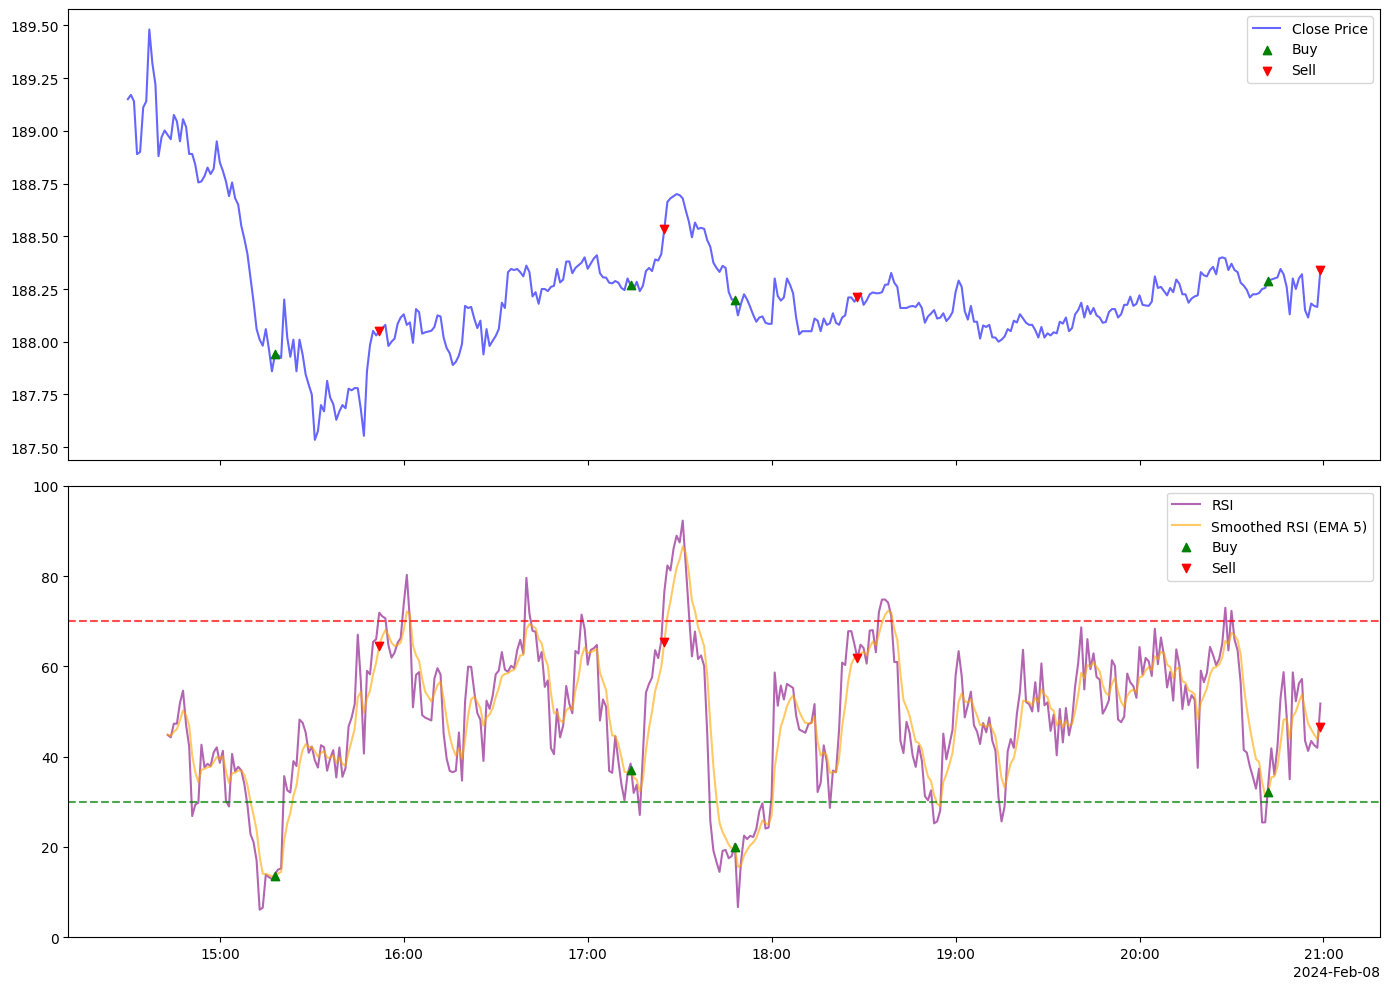

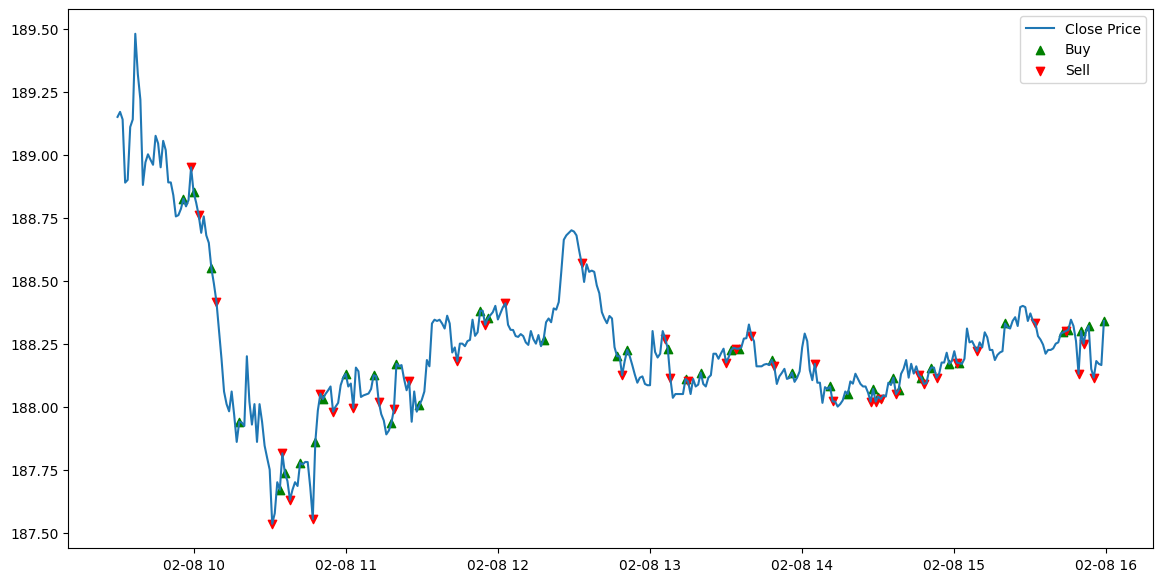

total profit is: -50.9141623390351


In [141]:
# Plot

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.scatter(df.loc[buy_signals].index, df.loc[buy_signals]['Close'], marker='^', color='green', label='Buy', alpha=1)
plt.scatter(df.loc[sell_signals].index, df.loc[sell_signals]['Close'], marker='v', color='red', label='Sell', alpha=1)
# plt.title('MACD and RSI Strategy')
plt.legend()
plt.show()
print('total profit is:', profit_or_loss)

In [106]:



# Example DataFrame loading (replace with your actual data loading method)
# df = pd.read_csv('path_to_your_amzn_hourly_data.csv', parse_dates=True, index_col='Date')

# Calculate MACD components
def calculate_macd(df, fast_period=9, slow_period=21, signal_period=9):
    df['EMA_fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA_slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA_fast'] - df['EMA_slow']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
    df['Histogram'] = df['MACD'] - df['Signal_Line']

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def simulate_macd_trading(df, initial_balance=10000):
    # Calculate the start date for the past month
    end_date = df.index.max()  # Assuming the DataFrame is indexed by date
    start_date = end_date - timedelta(days=30)

    # Filter the DataFrame to only include the last month's data
    df_last_month = df[(df.index >= start_date) & (df.index <= end_date)].copy()

    # Proceed with your existing logic but apply it to df_last_month
    calculate_macd(df_last_month)
    cash = initial_balance
    position = 0  # Number of shares held

    total_balance = [initial_balance]
    for i in range(1, len(df_last_month)):
        # Buy signal (MACD crosses above Signal Line)
        if df_last_month['MACD'].iloc[i-1] < df_last_month['Signal_Line'].iloc[i-1] and df_last_month['MACD'].iloc[i] > df_last_month['Signal_Line'].iloc[i]:
            # Buy only if we have no position
            if position == 0:
                position = cash / df_last_month['Close'].iloc[i]
                cash = 0
                print(f"Buying at {df_last_month.index[i]}, Price: {df_last_month['Close'].iloc[i]}")

        # Sell signal (MACD crosses below Signal Line)
        elif df_last_month['MACD'].iloc[i-1] > df_last_month['Signal_Line'].iloc[i-1] and df_last_month['MACD'].iloc[i] < df_last_month['Signal_Line'].iloc[i]:
            # Sell only if we have a position
            if position > 0:
                cash = position * df_last_month['Close'].iloc[i]
                position = 0
                print(f"Selling at {df_last_month.index[i]}, Price: {df_last_month['Close'].iloc[i]}")
                total_balance.append(cash)
    # Closing the position at the end of the period if still holding
    if position > 0:
        cash = position * df_last_month['Close'].iloc[-1]
    total_balance.append(cash)

    return cash - initial_balance, total_balance  # Return net profit or loss


# Assuming df is your DataFrame
profit_or_loss, balance_history = simulate_macd_trading(stock_data['AMZN'])

print(f"Net profit or loss: {profit_or_loss}")


Buying at 2024-01-10 10:50:00-05:00, Price: 153.36500549316406
Selling at 2024-01-10 11:10:00-05:00, Price: 153.23500061035156
Buying at 2024-01-10 12:10:00-05:00, Price: 153.70989990234375
Selling at 2024-01-10 13:15:00-05:00, Price: 154.00010681152344
Buying at 2024-01-10 14:15:00-05:00, Price: 154.27999877929688
Selling at 2024-01-10 14:35:00-05:00, Price: 154.1999969482422
Buying at 2024-01-11 09:30:00-05:00, Price: 157.0399932861328
Selling at 2024-01-11 10:05:00-05:00, Price: 154.38710021972656
Buying at 2024-01-11 12:15:00-05:00, Price: 154.0449981689453
Selling at 2024-01-11 14:20:00-05:00, Price: 155.17999267578125
Buying at 2024-01-12 09:40:00-05:00, Price: 155.6300048828125
Selling at 2024-01-12 10:00:00-05:00, Price: 154.8000030517578
Buying at 2024-01-12 11:05:00-05:00, Price: 155.17230224609375
Selling at 2024-01-12 11:40:00-05:00, Price: 154.6300048828125
Buying at 2024-01-12 12:30:00-05:00, Price: 154.51499938964844
Selling at 2024-01-12 12:35:00-05:00, Price: 154.32189

In [96]:
def calculate_30week_ma(ticker, stock_data, window=30):
    data = stock_data[ticker]

    # Calculate 30-week MA
    data['30_MA'] = data['Close'].rolling(window=window).mean()

    return data

def calculate_200day_ma(ticker, stock_data, window=200):
    data = stock_data[ticker]

    # Calculate 30-week MA
    data['200_MA'] = data['Close'].rolling(window=window).mean()

    return data

# apple_stock = calculate_30week_ma('AAPL', stock_data)
# print(apple_stock)

def find_stocks_crossing_above_ma(stock_data_in_memory):
    """
    Identifies stocks whose price has just crossed above their 30-week MA.

    Parameters:
    - stock_data_in_memory: A dictionary with ticker symbols as keys and DataFrames as values.
      Each DataFrame should have at least 'Close' and '30_MA' columns.

    Returns:
    - crossing_stocks: A list of ticker symbols for stocks that have just crossed above their 30-week MA.
    """
    crossing_stocks = []
    for ticker, data in stock_data_in_memory.items():
        # Ensure there's enough data to check the condition
        if len(data) < 2 or 'Close' not in data.columns or '30_MA' not in data.columns:
            continue

        # Check if the latest close is above the 30_MA and the previous close was below the 30_MA
        if data['Close'].iloc[-1] > data['30_MA'].iloc[-1] and \
           data['Close'].iloc[-2] > data['30_MA'].iloc[-2] and \
           data['Close'].iloc[-3] < data['30_MA'].iloc[-3] and \
           data['Volume'].iloc[-2] > data['Volume'].iloc[-3]:


            crossing_stocks.append(ticker)

    return crossing_stocks

def find_stocks_volume_boost(stock_data_in_memory):
    """
    Identifies stocks whose price has just crossed above their 30-week MA.

    Parameters:
    - stock_data_in_memory: A dictionary with ticker symbols as keys and DataFrames as values.
      Each DataFrame should have at least 'Close' and '30_MA' columns.

    Returns:
    - crossing_stocks: A list of ticker symbols for stocks that have just crossed above their 30-week MA.
    """
    volume_boost_stocks = []
    for ticker, data in stock_data_in_memory.items():
        # Ensure there's enough data to check the condition
        if len(data) < 2 or 'Close' not in data.columns:
            continue

        # past months' average volume
        volume_avg_past_month = sum([data['Volume'].iloc[i] for i in range(-30,0)])/30
        # print(volume_avg_past_month)
        # volume_avg_past_month =   data['Volume'].iloc[-2]

        for i in range(-3,0):
        # Check if the latest close is above the 30_MA and the previous close was below the 30_MA
            if data['Volume'].iloc[i] > 5*volume_avg_past_month and \
            data['Close'].iloc[i] > data['Open'].iloc[i]:
                volume_boost_stocks.append(ticker)

    return volume_boost_stocks

# calculate 30 week MA for all the stocks
# for ticker in stock_data:
#     _ = calculate_30week_ma(ticker, stock_data)

# breakouts = find_stocks_crossing_above_ma(stock_data)
# print(breakouts)

volume_boosts = find_stocks_volume_boost(stock_data)
print(volume_boosts)

[]


In [85]:
def calculate_squeeze_momentum_indicator(df):
    # Constants
    length = 20
    mult = 2.0
    lengthKC = 20
    multKC = 1.5

    # Bollinger Bands
    df['basis'] = df['Close'].rolling(window=length).mean()
    df['deviation'] = df['Close'].rolling(window=length).std()
    df['upperBB'] = df['basis'] + mult * df['deviation']
    df['lowerBB'] = df['basis'] - mult * df['deviation']

    # Keltner Channel
    df['TR'] = np.maximum((df['High'] - df['Low']),
                          np.maximum(abs(df['High'] - df['Close'].shift(1)),
                                     abs(df['Low'] - df['Close'].shift(1))))
    df['ATR'] = df['TR'].rolling(window=lengthKC).mean()
    df['ma'] = df['Close'].rolling(window=lengthKC).mean()
    df['upperKC'] = df['ma'] + df['ATR'] * multKC
    df['lowerKC'] = df['ma'] - df['ATR'] * multKC

    # Squeeze Logic
    df['squeeze_on'] = (df['lowerBB'] > df['lowerKC']) & (df['upperBB'] < df['upperKC'])
    df['squeeze_off'] = (df['lowerBB'] < df['lowerKC']) & (df['upperBB'] > df['upperKC'])

    # Momentum (Using linear regression slope as a proxy for momentum)
    df['momentum'] = np.nan
    for i in range(lengthKC, len(df)):
        y = df['Close'].iloc[i-lengthKC:i].values
        x = np.arange(0, len(y))
        slope = np.polyfit(x, y, 1)[0]  # First element is slope
        df.at[df.index[i], 'momentum'] = slope

    return df

def find_breakouts(stock_data):
    # Constants
    lengthKC = 20

    breakout_stocks = []
    for ticker, df in stock_data.items():
        if df is None or len(df) < lengthKC:
            continue

        df = calculate_squeeze_momentum_indicator(df)

        # Identify breakout condition: squeeze_off with positive momentum
        if df.iloc[-1]['squeeze_off'] and not df.iloc[-2]['squeeze_off'] and \
                df.iloc[-1]['momentum'] > 0:
            breakout_stocks.append(ticker)

    return breakout_stocks

# Assuming stock_data is a dictionary with S&P500 tickers as keys and their respective DataFrame as values
# Example: stock_data = {'AAPL': aapl_df, 'MSFT': msft_df, ...}
# AAPL_data = stock_data['AAPL']
breakout_stocks = find_breakouts(stock_data)
# calculate_squeeze_momentum_indicator(AAPL_data)
# print(AAPL_data)
print("Breakout Stocks:", breakout_stocks)


# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# def plot_squeeze_momentum(df, ticker):
#     fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

#     # Plotting the close price and 30-week MA on the first subplot
#     ax[0].plot(df.index, df['Close'], label='Close Price', color='blue')
#     ax[0].plot(df.index, df['30_MA'], label='30-Week MA', color='red', linestyle='--')
#     ax[0].set_ylabel('Price')
#     ax[0].legend()
#     ax[0].grid(True)

#     # Plotting the squeeze momentum on the second subplot
#     colors = df['momentum'].apply(lambda x: 'green' if x > 0 else 'red')
#     ax[1].bar(df.index, df['momentum'], color=colors, width=5)

#     # Highlighting the squeeze condition
#     squeeze_colors = df.apply(lambda row: 'black' if row['squeeze_on'] else ('gray' if row['squeeze_off'] else 'blue'), axis=1)
#     ax[1].bar(df.index, df['momentum'], color=squeeze_colors, width=2, alpha=0.5)

#     ax[1].set_ylabel('Momentum')
#     ax[1].axhline(0, color='black', linewidth=0.8)  # Zero line for momentum
#     ax[1].grid(True)

#     # Formatting the date on the x-axis
#     ax[1].xaxis.set_major_locator(mdates.YearLocator())
#     ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#     ax[1].xaxis.set_minor_locator(mdates.MonthLocator())
#     ax[1].xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
#     plt.setp(ax[1].xaxis.get_minorticklabels(), rotation=45)

#     plt.title(f"{ticker} - Squeeze Momentum Indicator")
#     plt.tight_layout()
#     plt.show()

# for ticker in breakout_stocks:
#     plot_squeeze_momentum(stock_data[ticker],ticker)

Breakout Stocks: ['ALGN', 'BWA', 'EXPE', 'ICE', 'LDOS', 'MAS', 'PYPL', 'LUV']


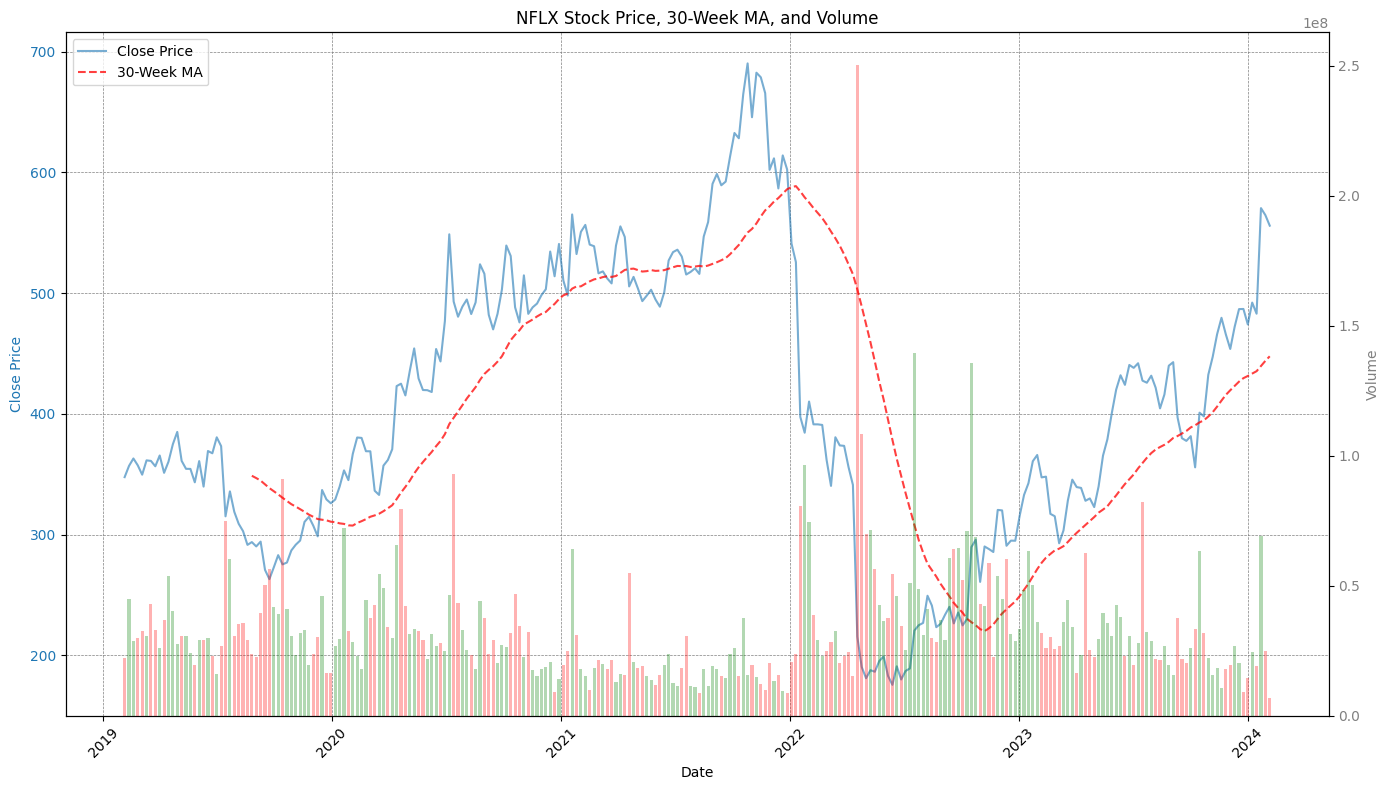

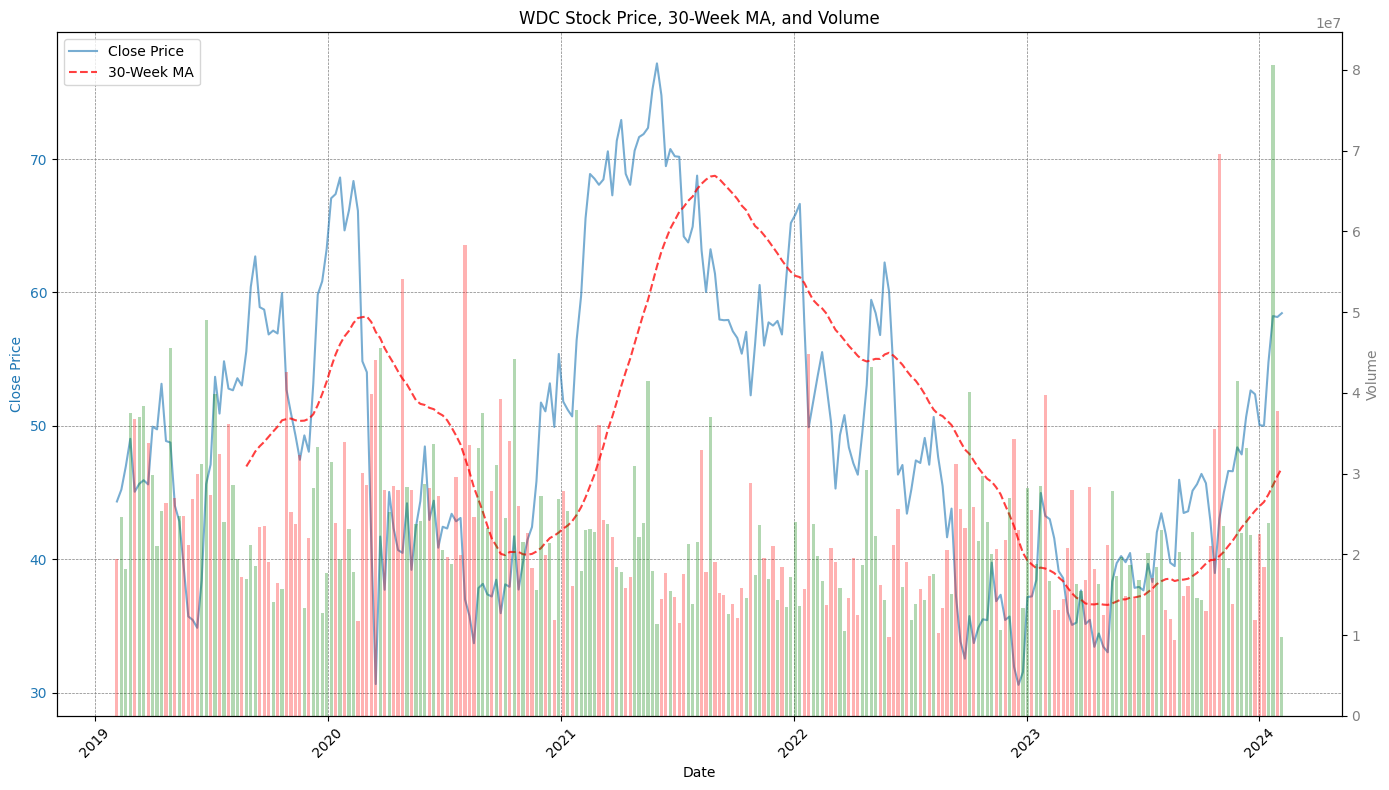

In [60]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_stock_price_ma_and_volume(df, ticker):
    # Create a figure and a grid of subplots
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plotting the closing price and 30-week MA
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(df.index, df['Close'], label='Close Price', color=color, alpha=0.6)
    ax1.plot(df.index, df['30_MA'], label='30-Week MA', color='red', linestyle='--', alpha=0.75)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')

    # Instantiate a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Volume', color='grey')

    # Iterate over each day to color the volume bars
    for index, row in df.iterrows():
        if row['Close'] > row['Open']:  # Close is higher than open
            ax2.bar(index, row['Volume'], color='green', alpha=0.3, width=5)
        else:  # Close is lower or equal to open
            ax2.bar(index, row['Volume'], color='red', alpha=0.3, width=5)

    ax2.tick_params(axis='y', labelcolor='grey')

    # Setting the major locator for x-axis (date)
    ax2.xaxis.set_major_locator(mdates.YearLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Rotating the date labels to improve readability
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    plt.title(f"{ticker} Stock Price, 30-Week MA, and Volume")
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

# Example usage
# Make sure df is your DataFrame containing the stock data for a particular ticker
# For instance, if you have AAPL's stock data in df:
# plot_stock_price_ma_and_volume(apple_stock, "AAPL")
for ticker in volume_boosts:
    plot_stock_price_ma_and_volume(stock_data[ticker],ticker)

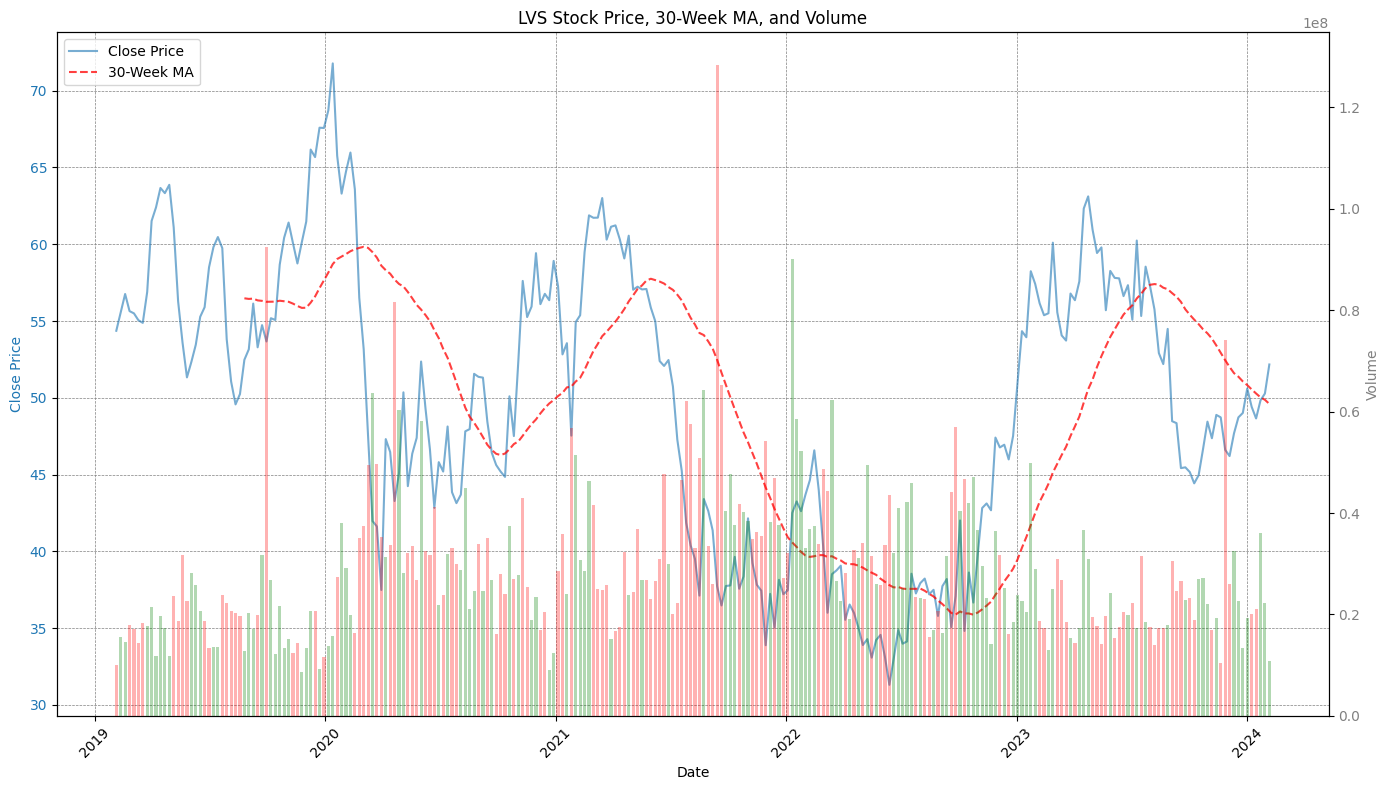

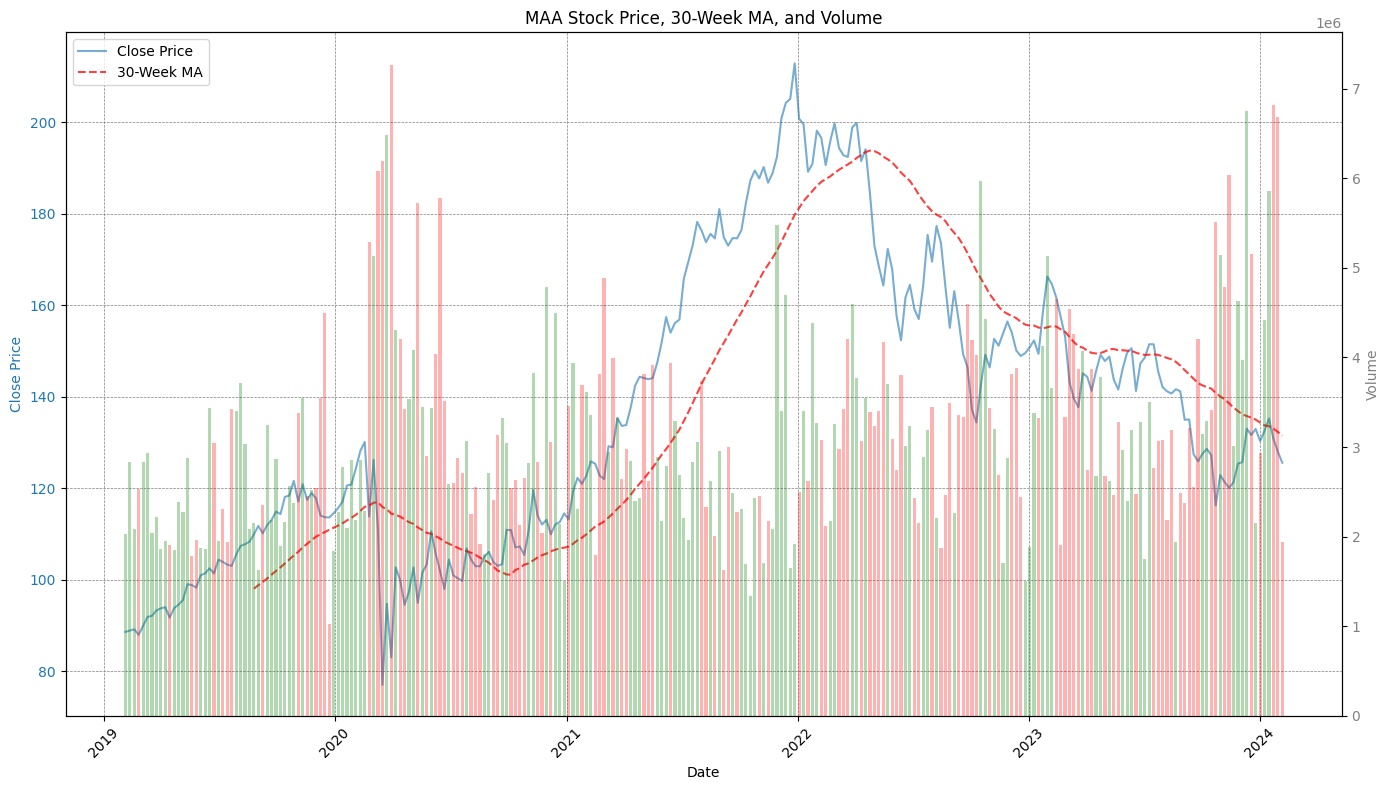

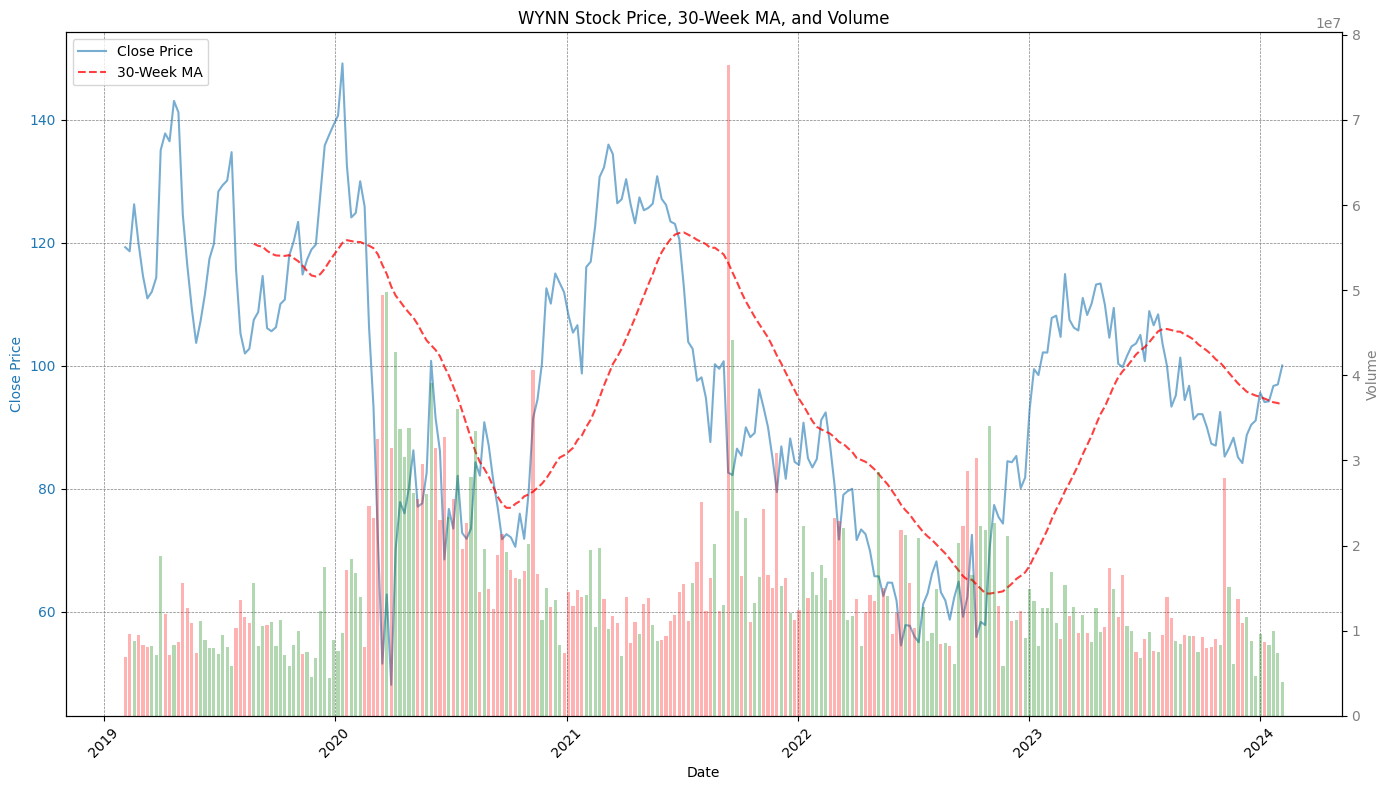

In [66]:
for ticker in breakout_stocks:
    plot_stock_price_ma_and_volume(stock_data[ticker],ticker)

In [18]:


def calculate_slope(series, slope_window):
    """Calculates the slope of the MA series using linear regression for the last 30 values."""
    print(series)
    print(slope_window)
    y = series.dropna().values[-slope_window:]  # Use only the last 4 non-NA values
    print(y)
    x = np.arange(len(y))
    slope, intercept, _, _, _ = linregress(x, y)
    return slope

def calculate_normalized_slop(ticker, slope_window=4):
    """Fetch the normalized ma data and find the slope."""
    data = calculate_and_save_normalized_ma(ticker)
    # print(data)

    # Calculate the slope of the MA
    slope = calculate_slope(data['Normalized_30_MA'],slope_window)

    return slope

def process_stocks(tickers):
    """Processes stocks to fetch data, calculate MA, save both, and determine slopes for ranking."""
    stock_slopes = []
    for ticker in tickers:
        slope = calculate_normalized_slop(ticker)
        stock_slopes.append((ticker, slope))
    # Sort and select top 10 stocks based on the absolute value of their slope
    top_stocks_by_slope = sorted(stock_slopes, key=lambda x: abs(x[1]), reverse=True)[:10]
    return top_stocks_by_slope

# Execution
sp500_tickers = fetch_sp500_tickers()
top_stocks_by_slope = process_stocks(["AAPL"])

# Output the top 10 stocks with the steepest MA slopes
for stock, slope in top_stocks_by_slope:
    print(f"Ticker: {stock}, MA Slope: {slope}")


Date
2019-01-28 00:00:00-05:00         NaN
2019-02-04 00:00:00-05:00         NaN
2019-02-11 00:00:00-05:00         NaN
2019-02-18 00:00:00-05:00         NaN
2019-02-25 00:00:00-05:00         NaN
                               ...   
2024-01-01 00:00:00-05:00    0.998757
2024-01-08 00:00:00-05:00    0.999027
2024-01-15 00:00:00-05:00    1.000000
2024-01-22 00:00:00-05:00    0.999813
2024-01-29 00:00:00-05:00    0.999214
Name: Normalized_30_MA, Length: 262, dtype: float64
4
[0.99902723 1.         0.99981302 0.99921378]
Ticker: AAPL, MA Slope: 3.726810782218592e-05


In [3]:
print(len(stage_2_stocks))

257
